This notebook conducts a posterior predictive test for whether we can detect a non-GR theory of gravity using $E_G$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fiducial as fid
import utils as u
import scipy.stats 
from scipy.stats import chi2
from scipy.stats import rv_histogram
from scipy.stats import binned_statistic
import specs as sp 

Define parameters etc.

In [2]:
# Parameters

lens = 'DESI'
src = 'LSST'
Pimax=300.
rp0 = 1.5

# Number of E_G samples to draw:
#Nsamp = 1000

endfilename = 'post_pred_Jan15'

# Use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

OmM = 0.292

# Using now nonliner bias parameters as fit in Kitanis & White 2022. 
# They fit LTP parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers
#Nsamps=100000

print('b1=', b1)
print('b2=', b2)
print('bs=', bs)

# A_s value is designed to match sigma8=0.82 in LCDM for other cosmological parameters. 
# We do this by manually finding the value of A_s that gives the right sigma8 using ccl_sigma8.

# Define Gaussian uncertainty for prior distribution on OmegaM0

# DES year 3 gives OmegaM0 = 0.339 + 0.032 - 0.031 for LCDM model. 
# Let's use roughly this error with our fiducial for the mean.
OmMerr = 0.03

# nDGP
Omega_rc = 0.5
h0rc = 1./np.sqrt(4*Omega_rc)
print('H0rc=', h0rc)

# f(R)
fr0 = 10**(-4)

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965,'b':b1, 'OmM': OmM, 'b_2':b2, 'b_s': bs, 'fR0' : fr0, 'A_s':2.115 * 10**(-9), 'fR_n': 1, 'H0rc':h0rc} 

b1= 2.333
b2= 1.021809523809524
bs= -0.38085714285714284
H0rc= 0.7071067811865475


In [3]:
# Compute the mean redshift over the lenses, we need this later:

zvec, dNdz = sp.get_dNdzL(params, 'DESI')

zbar = scipy.integrate.simps(zvec*dNdz, zvec)
print('zbar=', zbar)

zbar= 0.7226958808077818


Load data covariance and rp bins stuff

In [4]:
# Covariance matrix:
# Notice this is the bias-correction version.
egcov = np.loadtxt('../txtfiles/cov_EG_nLbiascorrected.dat')

inv_egcov = np.linalg.inv(egcov)

# Scale cuts. 0 means cut the bin, 1 means keep it.
rp_c_scalecuts, scalecuts = np.loadtxt('../txtfiles/scalecuts_nLbias_CORRECTIONFACTOR_KitanidisWhite2022.dat', unpack=True)

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)

#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)-1
rp_bin_c = rp_bin_c_raw[ind:]
rp_bin_edges = rp_bin_edges_raw[ind:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  1.21375641   1.60004256   2.10926689   2.78055529   3.66548575   4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


In [10]:
# Begin loop over draws from data realisations.
# To get this working, first try just a small number of data realisations for quick debugging.
Nsamp=5

# Set up arrays and other stuff needed to store things over multiple data realisations

# For the fit to constant model of the E_G data realisation:
vals = np.linspace(0.01,0.99,10000) # values at which we grid-sampl E_G constant model
loglike_vals = np.zeros((Nsamp, len(vals)))
like_vals = np.zeros((Nsamp, len(vals)))
like_vals_norm = np.zeros((Nsamp, len(vals)))
max_post_val = np.zeros(Nsamp) # best fit E_G constant model at a given realisation
chisq = np.zeros(Nsamp) # chisq of the best fit constant model with data realisation
cdf_samps = np.zeros(Nsamp)
const_bad_fit = np.zeros(Nsamp)

# For getting the posterior on OmegaM0 in the GR model:
OmMvals = np.linspace(0.1,0.5,10000) # values at which grid sample OmegaM0
logP_OmM = -0.5*(OmMvals - params['OmM'])**2/(OmMerr**2) # define DES Y3 LCDM prior
EGvals = fid.EG_theory(OmMvals, zbar) # Get corrsponding EG values
loglike_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_norm_OmM = np.zeros((Nsamp, len(OmMvals)))

outside_95 = np.zeros(Nsamp)


for i in range(0, Nsamp):

    #### GENERATE DATA REALISATION ####

    # Draw from OmegaM0 prior.
    OmMsamp = np.random.normal(params['OmM'], OmMerr, 1)
    print('OmMsamp=', OmMsamp)
    print('params OmM=', params['OmM'])

    # Using this value of OmegaM0, compute corresponding E_G 
    # (we assume this has been fully corrected for nonlinear
    # bias as we cannot compute the nonlinear bias correction
    # outside GR.

    # Compute E_G - alter final argument different gravity theory.
    EG_fid = fid.E_G(params, rp_bin_edges, rp0, lens, src, 
                 Pimax, endfilename, nonlin=False, MG=True, MGtheory='nDGP')

    # Using this as a mean with Eg_cov, draw a data realisation.
    EG_data = np.random.multivariate_normal(EG_fid, egcov, 1)

    print(EG_data.shape)

    #### FIT CONSTANT TO DATA REALISATION DRAW ####

    # Sample the likelihood. It's only a one dimensional parameter space so we can just grid-sample.

    for j in range(0,len(vals)):
        loglike_vals[i,j] = u.logL(vals[j], EG_data[0,:], inv_egcov)
        like_vals[i,j] = np.exp(loglike_vals[i,j])
        like_vals_norm[i,:] = like_vals[i,:]/ scipy.integrate.simps(like_vals[i,:], vals)

    # Get the maximum of the poterior point of the fit to the constant, 
    max_post_ind = np.argmax(like_vals_norm[i,:])
    max_post_val[i] = vals[max_post_ind]

    # Get the chi^2
    chisq[i] = 0.5*np.dot((max_post_val[i] - EG_data[0,:]), 
                          np.dot(inv_egcov, (max_post_val[i] - EG_data[0,:])))
    
    # We want to look at a chi squared distribution with the correct number 
    # of degrees of freedom

    # Define the number of degrees of freedom:
    len_cut_dvec = len(EG_data[0,:])
    model_par = 1 # 1 parameter for a constant model
    DOF = len_cut_dvec - model_par

    # What we want is the CDF value at the chi square.
    # What this tells us is the probability that, given our constant model 
    # is correct, we would have got the chi square we got or a lower chi squared (fixing our measured data vector and cov).
    # Eg if CDF = 0.95, this means that if our model is correct, 95% of the time the chi squared would have been lower.
    # If we care about the model and the data agreeing within 1 sigma, we look for the case where CDF=0.68 or less
    # i.e. the case where if our model is correct, 68% of the time we would have drawn a lower chi-squared. 
    cdf_samps[i] = chi2.cdf(chisq[i], DOF)

    # Set to 1 where the cdf>=0.95 (corresponds to p value 0.05)
    if cdf_samps[i]>=0.95:
        const_bad_fit[i] = 1
        break # No point in continuing in this case, we already know we reject GR

    #### GET POSTERIOR IN OMEGA_M_0_FIT IN GR MODEL ####

    for j in range(0,len(OmMvals)):
        loglike_vals_OmM[i,j] = u.logL(EGvals[j], EG_data[0,:], inv_egcov)
        #like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j])
        like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j] + logP_OmM[j]) # This version adds a prior.
    like_vals_norm_OmM[i,:] = like_vals_OmM[i,:]/ scipy.integrate.simps(like_vals_OmM[i,:], OmMvals)

    # Define a pdf on OmM from posterior values computed above.
    bin_means, bin_edges, bin_number = binned_statistic(OmMvals, like_vals_norm_OmM[i], statistic ='mean',bins=200)
    hist_OmM = bin_means, bin_edges

    # can set density=True because normalised values.
    OmMfit_dist = rv_histogram(hist_OmM, density = True)

    #### GET REPLICATED E_G DATA UNDER GR MODEL ####

    # Sample values from this distribution
    N_OmMfitsamp = 10000
    OmMfitsamps = OmMfit_dist.rvs(size=N_OmMfitsamp)

    # Get corresponding GR theory E_G values:
    EG_rep_data = fid.EG_theory(OmMfitsamps, zbar)

    # Get distribution of GR value for E_G.

    EG_rep_hist = np.histogram(EG_rep_data, bins = 50, density=True)
    EG_rep_dist = rv_histogram(EG_rep_hist, density=True)

    # Get the 5% and 95% confidence points of the distribution 

    ninetyfive_intervals_EGrep = EG_rep_dist.interval(0.95)

    # Does the constant best fit value to the original data fall
    # outside the 95%?

    if max_post_val[i] <= ninetyfive_intervals_EGrep[0] or max_post_val[i]>= ninetyfive_intervals_EGrep[1]:
        outside_95[i] = 1    

OmMsamp= [0.29695848]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
(1, 16)
OmMsamp= [0.29578374]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
(1, 16)
OmMsamp= [0.29194163]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
(1, 16)
OmMsamp= [0.2648494]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
(1, 16)
OmMsamp= [0.25626725]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
(1, 16)


In [11]:
num_bad_fit = np.sum(const_bad_fit)
num_outside_95 = np.sum(outside_95)

total_reject = num_bad_fit + num_outside_95

frac_reject = total_reject / Nsamp

print('we reject GR ', total_reject, ' times out of ', Nsamp,' so fractional reject rate is ', frac_reject)

we reject GR  0.0  times out of  5  so fractional reject rate is  0.0


BELOW HERE IS THE SAME FUNCTIONALITY BUT NOT IN A LOOP - IGNORE

In [6]:
# Fit constant model to the data (get code from previous forecast notebook.)

# Sample the likelihood. It's only a one dimensional parameter space so we can just grid-sample.

vals = np.linspace(0.01,0.99,10000)

# I don't need multiple 'Nsamps' right now but I probably will
# once I put this in a loop so let's keep this infrastructure.
loglike_vals = np.zeros((Nsamp, len(vals)))
like_vals = np.zeros((Nsamp, len(vals)))
like_vals_norm = np.zeros((Nsamp, len(vals)))

for i in range(0,Nsamp):
    for j in range(0,len(vals)):
        loglike_vals[i,j] = u.logL(vals[j], EG_data[i,:], inv_egcov)
        like_vals[i,j] = np.exp(loglike_vals[i,j])
    like_vals_norm[i,:] = like_vals[i,:]/ scipy.integrate.simps(like_vals[i,:], vals)

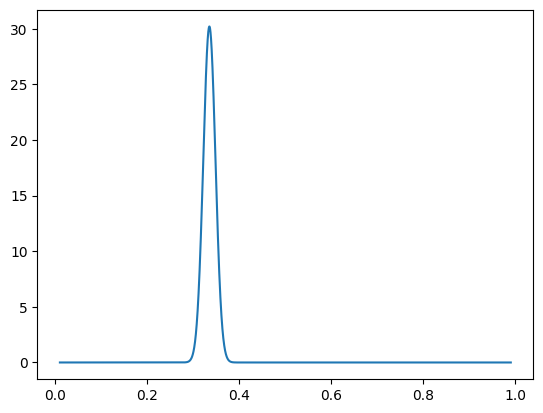

In [7]:
plt.figure()
plt.plot(vals, like_vals_norm[0])
plt.show()

Might need to be in loop:

Do a chi^2 check of whether this is a good fit.

In [8]:
# chi^2 check if this is a good fit.

# If it's a bad fit, record this as a 'reject GR' case (within loop).

# Get the maximum of the poterior point of the fit to the constant, 
# We could also use the mean. 
# I think it will be pretty similar for the posteriors we are seeing 
# because they appear very Gaussian.

max_post_val = np.zeros(Nsamp)
for i in range(0,Nsamp):
    max_post_ind = np.argmax(like_vals_norm[i,:])
    max_post_val[i] = vals[max_post_ind]
    #print('i=', i,'max val=', max_post_val[i])

# Get the chi^2
chisq = np.zeros(Nsamp)
for i in range(0, Nsamp):
    chisq[i] = 0.5*np.dot((max_post_val[i] - EG_data[i,:]), 
                          np.dot(inv_egcov, (max_post_val[i] - EG_data[i,:])))
    
# We want to look at a chi squared distribution with the correct number 
# of degrees of freedom

# Define the number of degrees of freedom:
len_cut_dvec = len(EG_data[0,:])
model_par = 1 # 1 parameter for a constant model
DOF = len_cut_dvec - model_par

# What we want is the CDF value at the chi square.
# What this tells us is the probability that, given our constant model 
# is correct, we would have got the chi square we got or a lower chi squared (fixing our measured data vector and cov).
# Eg if CDF = 0.95, this means that if our model is correct, 95% of the time the chi squared would have been lower.
# If we care about the model and the data agreeing within 1 sigma, we look for the case where CDF=0.68 or less
# i.e. the case where if our model is correct, 68% of the time we would have drawn a lower chi-squared. 

cdf_samps = np.zeros(Nsamp)
for i in range(0,Nsamp):
    cdf_samps[i] = chi2.cdf(chisq[i], DOF)
    #print('i=', i,', cdf=', cdf_samps[i])

# Check which of these, if any are  >=0.95
# Will need to alter this a bit when making the loop.
const_bad_fit = np.zeros(Nsamp) # Set to 1 where the cdf>=0.95 (corresponds to p value 0.05)
for i in range(0,Nsamp):
    if cdf_samps[i]>=0.95:
        const_bad_fit[i] = 1

num_bad_fit = np.sum(const_bad_fit)

print('num_bad_fit=', num_bad_fit)
print('which ones?=',np.where(const_bad_fit==1))
inds_bad_fit = np.where(const_bad_fit==1)




num_bad_fit= 0.0
which ones?= (array([], dtype=int64),)


In loop:

If constant is good fit: Get get posterior for OmegaM0 model.

In [9]:
# Sample OmegaM0 and get posterior given GR prediction.
# Result: posterior for OmegaM0 under GR model and sampled data.
# We draw from a flat prior to normalised likelihood = posterior.

# again it is 1-D parameter space so we can grid-sample

# This is a uniform prior right now. Maybe we use the same prior as above, from DES Y3 - does this change anything?
OmMvals = np.linspace(0.1,0.5,10000)

logP_OmM = -0.5*(OmMvals - params['OmM'])**2/(OmMerr**2)

EGvals = fid.EG_theory(OmMvals, zbar)

# Nsamp is still 1 for us here but will change if we put this in a loop.

loglike_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_norm_OmM = np.zeros((Nsamp, len(OmMvals)))
interp_OmM_post = [0]*Nsamp # list to hold interpolating functions

for i in range(0,Nsamp):
    for j in range(0,len(OmMvals)):
        loglike_vals_OmM[i,j] = u.logL(EGvals[j], EG_data[i,:], inv_egcov)
        #like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j])
        like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j] + logP_OmM[j]) # This version adds a prior.
    like_vals_norm_OmM[i,:] = like_vals_OmM[i,:]/ scipy.integrate.simps(like_vals_OmM[i,:], OmMvals)
    interp_OmM_post[i] = scipy.interpolate.interp1d(OmMvals, like_vals_norm_OmM[i,:])


In loop:

Draw from the OmegaM0 distribution and compute corresponding $E_G$ (constant) values under the GR model. Get a bunch of GR values of E_G.

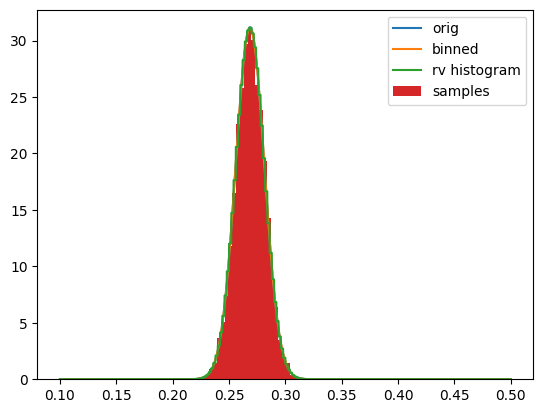

In [10]:
# Draw from OmegaM0 posterior and compute 
# corresponding constant E_G using GR definition.

# Define a pdf on OmM from posterior values computed above.

bin_means, bin_edges, bin_number = binned_statistic(OmMvals, like_vals_norm_OmM[0], statistic ='mean',bins=200)

hist_OmM = bin_means, bin_edges

# can se density=True because normalised values.
OmMfit_dist = rv_histogram(hist_OmM, density = True)

# Sample values
N_OmMfitsamp = 10000
OmMfitsamps = OmMfit_dist.rvs(size=N_OmMfitsamp)

# Check this looks right:
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

plt.figure()
plt.plot(OmMvals, like_vals_norm_OmM[0], label='orig')
plt.plot(bin_centers, bin_means, label='binned')
plt.plot(OmMvals, OmMfit_dist.pdf(OmMvals), label='rv histogram')
plt.hist(OmMfitsamps, bins = 30, label='samples', density=True)
plt.legend()
plt.show()

# Get corresponding GR theory E_G values:
EG_rep_data = fid.EG_theory(OmMfitsamps, zbar)
    

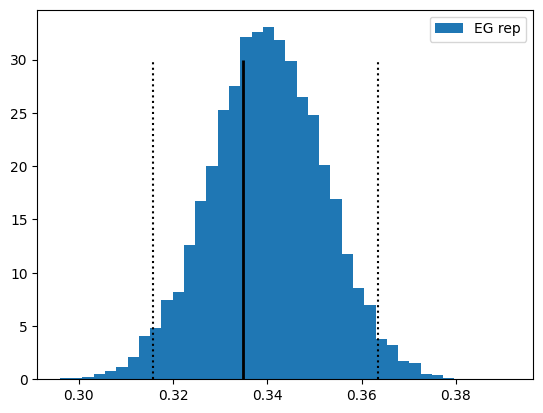

total outside 95%= 0


In [11]:
# Get distribution of GR value for E_G.

EG_rep_hist = np.histogram(EG_rep_data, bins = 50, density=True)

EG_rep_dist = rv_histogram(EG_rep_hist, density=True)

# Get the 5% and 95% confidence points of the distribution 

ninetyfive_intervals_EGrep = EG_rep_dist.interval(0.95)

plt.figure()
plt.hist(EG_rep_data, bins = 40, label='EG rep', density=True)
plt.vlines(ninetyfive_intervals_EGrep[0], ymin=0, ymax=30, color='k', linestyle=':')
plt.vlines(ninetyfive_intervals_EGrep[1], ymin=0, ymax=30, color='k', linestyle=':')
plt.vlines(max_post_val[0], ymin=0, ymax=30, color='k', linewidth=2)

plt.legend()
plt.show()

# Does the constant best fit value to the original data fall
# outside the 95%?

# Need to update this if we cut the ones where it's a bad fit.
inds_low = np.where(max_post_val <= ninetyfive_intervals_EGrep[0])
inds_high = np.where(max_post_val>= ninetyfive_intervals_EGrep[1])

total_outside_95 = len(inds_low[0])+ len(inds_high[0])

print('total outside 95%=', total_outside_95)

# If yes, consider GR rejected for this case. 

In [20]:
print('best fit for sample in current nDGP universe:', max_post_val)
print('GR theory with same OmM=', fid.EG_theory(OmMsamp, zbar))

best fit for sample in current nDGP universe: [0.37175418]
GR theory with same OmM= [0.38023084]
